
# Titanic Survival Predictor (Notebook)

This notebook trains a **Titanic survival** classifier using a resilient data-loading pattern similar to your example:
- Try multiple public sources (with/without headers)
- Normalize column names to a standard schema
- Save a local cached CSV under `data/titanic.csv` for reproducibility

It then performs cleaning, feature engineering, modeling (Logistic Regression & Random Forest), evaluation, feature importance, and model export.


In [1]:

# Core imports
from pathlib import Path
import io
from urllib.request import urlopen

import numpy as np
import pandas as pd

# Modeling & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Saving model
import joblib

# Plotting
import matplotlib.pyplot as plt

print("Versions →", {
    "numpy": np.__version__,
    "pandas": pd.__version__,
})


Versions → {'numpy': '2.0.2', 'pandas': '2.2.2'}


## Data loading with multiple sources and header handling

In [2]:

# Two public sources with slightly different schemas.
# (Kaggle originals require auth; these mirrors are open.)
SOURCES = [
    # Datasciencedojo version (has many columns incl. Name, Ticket, Cabin, Embarked)
    "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv",
    # Plotly version (columns slightly different; e.g., 'Siblings/Spouses Aboard')
    "https://raw.githubusercontent.com/plotly/datasets/master/titanic.csv",
]

# We'll standardize to these columns when possible.
COLUMNS = ["Survived","Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]

data_path = Path('data/titanic.csv')
data_path.parent.mkdir(parents=True, exist_ok=True)

# Helper: unify schema across variants
def normalize_titanic_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Work on a copy
    df = df.copy()

    # Common alternative column names
    rename_map = {
        'Siblings/Spouses Aboard': 'SibSp',
        'Parents/Children Aboard': 'Parch',
        'siblings/spouses aboard': 'SibSp',
        'parents/children aboard': 'Parch',
        'pclass': 'Pclass',
        'sex': 'Sex',
        'age': 'Age',
        'sibsp': 'SibSp',
        'parch': 'Parch',
        'fare': 'Fare',
        'embarked': 'Embarked',
        'survived': 'Survived',
    }

    # Lowercase -> attempt rename, then titlecase back where applicable
    lower_cols = {c: c.lower() for c in df.columns}
    df.columns = [lower_cols[c] for c in df.columns]
    df.rename(columns=rename_map, inplace=True)

    # Fix titlecase for known set
    df.rename(columns={
        'pclass': 'Pclass',
        'sex': 'Sex',
        'age': 'Age',
        'sibsp': 'SibSp',
        'parch': 'Parch',
        'fare': 'Fare',
        'embarked': 'Embarked',
        'survived': 'Survived',
    }, inplace=True)

    # If 'PassengerId' is present, we don't need it
    drop_candidates = ["PassengerId", "passengerid", "Name", "name", "Ticket", "ticket", "Cabin", "cabin"]
    for col in drop_candidates:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    # If the Plotly version lacks Embarked, create it as NaN (will be imputed later)
    import numpy as _np
    if 'Embarked' not in df.columns:
        df['Embarked'] = _np.nan

    # Ensure columns exist; if some are missing, add as NaN
    for col in COLUMNS:
        if col not in df.columns:
            df[col] = _np.nan

    # Finally, keep only our standard set (order matters)
    df = df[COLUMNS]
    return df

def try_download():
    for url in SOURCES:
        try:
            print(f'Trying {url} ...')
            with urlopen(url, timeout=20) as resp:
                text = resp.read().decode('utf-8')
            # Try to read as CSV directly
            df_raw = pd.read_csv(io.StringIO(text))
            # If it came without headers (unlikely for these sources), synthesize generic headers
            if list(df_raw.columns) == list(range(df_raw.shape[1])):
                # Make a best-effort guess — we will just assign plausible headers and normalize
                guessed = df_raw
                guessed.columns = [f"col_{i}" for i in range(df_raw.shape[1])]
                df = normalize_titanic_columns(guessed)
            else:
                df = normalize_titanic_columns(df_raw)

            # Save local copy
            df.to_csv(data_path, index=False)
            print('Downloaded and saved to', data_path.resolve())
            return df
        except Exception as e:
            print('  Failed:', e)
    return None

# Load local or download
if data_path.exists():
    df = pd.read_csv(data_path)
    print('Loaded local data from', data_path.resolve())
else:
    df = try_download()
    if df is None:
        raise RuntimeError(
            "Could not download dataset. Please place a file 'data/titanic.csv' locally "
            "with columns: " + ", ".join(COLUMNS)
        )

df.head()


Trying https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv ...
Downloaded and saved to /content/data/titanic.csv


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Quick EDA

In [3]:

display(df.describe(include='all').T)
print("\nMissing values per column:\n", df.isna().sum())


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing values per column:
 Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


## Train/test split and preprocessing

In [4]:

# Target and features
target = "Survived"
X = df.drop(columns=[target])
y = df[target].astype(int)  # ensure binary ints 0/1

# Simple train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_features = ["Age", "Fare", "Pclass", "SibSp", "Parch"]
categorical_features = ["Sex", "Embarked"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Two candidate models
log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight=None
    ))
])

# Cross-validate both
for name, model in [("LogisticRegression", log_reg), ("RandomForest", rf)]:
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")
    print(f"{name} ROC-AUC (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


LogisticRegression ROC-AUC (CV): 0.856 ± 0.023
RandomForest ROC-AUC (CV): 0.853 ± 0.038


## Train final model and evaluate


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.810     0.891     0.848       110
           1      0.793     0.667     0.724        69

    accuracy                          0.804       179
   macro avg      0.802     0.779     0.786       179
weighted avg      0.803     0.804     0.801       179

ROC-AUC: 0.844


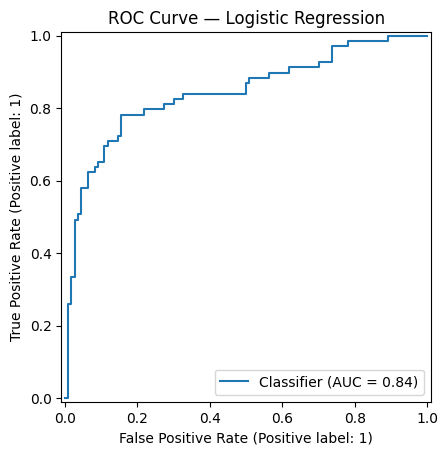

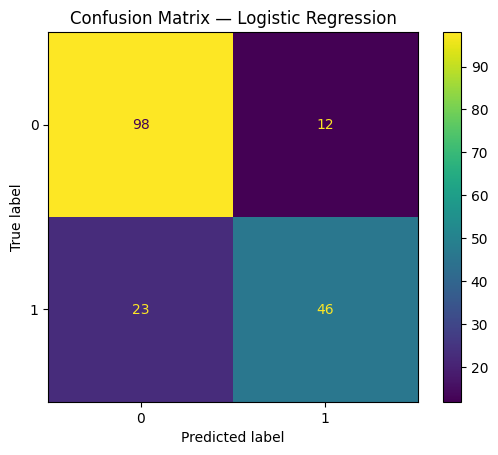


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.824     0.891     0.856       110
           1      0.800     0.696     0.744        69

    accuracy                          0.816       179
   macro avg      0.812     0.793     0.800       179
weighted avg      0.814     0.816     0.813       179

ROC-AUC: 0.834


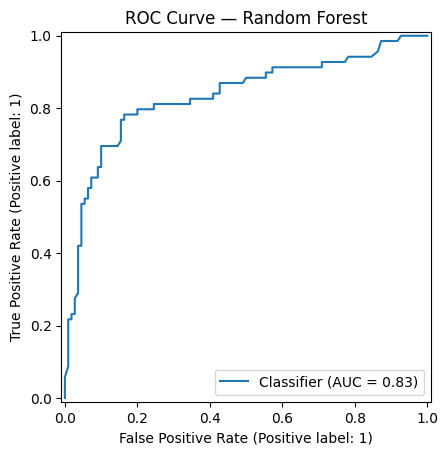

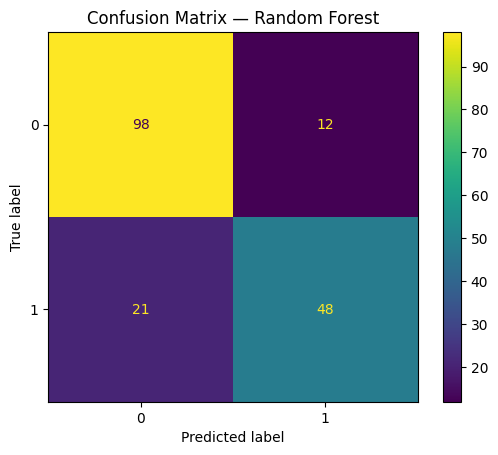


Best model selected: LogisticRegression (AUC: 0.844)


In [5]:

# Fit both and pick the better on validation ROC-AUC quickly
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

def eval_model(pipe, label):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None
    print(f"\n=== {label} ===")
    print(classification_report(y_test, y_pred, digits=3))
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC: {auc:.3f}")
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC Curve — {label}")
        plt.show()

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix — {label}")
    plt.show()

eval_model(log_reg, "Logistic Regression")
eval_model(rf, "Random Forest")

# Choose best based on test ROC-AUC (fallback: accuracy if proba missing)
def get_auc(pipe):
    proba = pipe.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, proba)

auc_log = get_auc(log_reg)
auc_rf  = get_auc(rf)

best_model, best_name = (rf, "RandomForest") if auc_rf >= auc_log else (log_reg, "LogisticRegression")
print(f"\nBest model selected: {best_name} (AUC: {max(auc_rf, auc_log):.3f})")


## Feature importance / coefficients

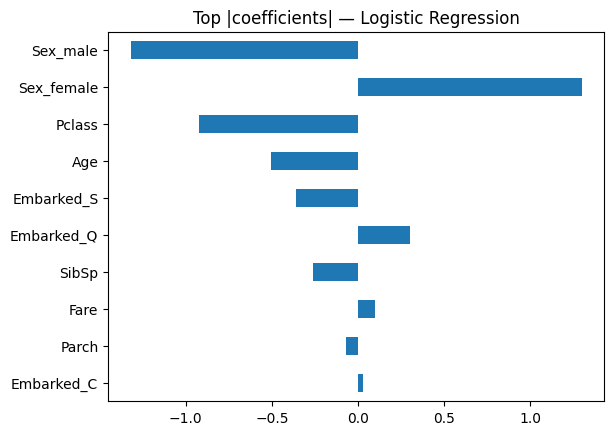

,feature,importance
0,Sex_female,1.299444
1,Embarked_Q,0.304784
2,Fare,0.100269
3,Embarked_C,0.032247
4,Parch,-0.066424
5,SibSp,-0.260607
6,Embarked_S,-0.358305
7,Age,-0.502815
8,Pclass,-0.921972
9,Sex_male,-1.320718


In [6]:

# Extract feature names after preprocessing
preprocessor = best_model.named_steps["preprocess"]

num_feats = preprocessor.transformers_[0][2]
cat_feats = list(preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_features))
all_features = list(num_feats) + cat_feats

if best_name == "LogisticRegression":
    coefs = best_model.named_steps["clf"].coef_[0]
    imp = pd.Series(coefs, index=all_features).sort_values(key=np.abs, ascending=False)
    imp.head(20).plot(kind="barh")
    plt.title("Top |coefficients| — Logistic Regression")
    plt.gca().invert_yaxis()
    plt.show()
else:
    importances = best_model.named_steps["clf"].feature_importances_
    imp = pd.Series(importances, index=all_features).sort_values(ascending=True)
    imp.tail(20).plot(kind="barh")
    plt.title("Top Feature Importances — Random Forest")
    plt.show()

imp_df = imp.sort_values(ascending=False).reset_index()
imp_df.columns = ["feature","importance"]
display(imp_df.head(25))


## Save trained model

In [7]:

models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)
model_path = models_dir / f"titanic_{best_name.lower()}.joblib"
joblib.dump(best_model, model_path)
print("Saved model to:", model_path.resolve())


Saved model to: /content/models/titanic_logisticregression.joblib


## Inference example

In [8]:

# Example passenger(s): list of dicts
example = pd.DataFrame([
    {"Pclass": 3, "Sex": "male",   "Age": 22.0, "SibSp": 1, "Parch": 0, "Fare": 7.25,  "Embarked": "S"},
    {"Pclass": 1, "Sex": "female", "Age": 38.0, "SibSp": 1, "Parch": 0, "Fare": 71.28, "Embarked": "C"},
])

loaded = joblib.load(model_path)
pred_proba = loaded.predict_proba(example)[:,1]
pred = loaded.predict(example)
out = example.copy()
out["Survival_Prob"] = pred_proba
out["Survival_Pred"] = pred
display(out)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survival_Prob,Survival_Pred
0,3,male,22.0,1,0,7.25,S,0.088635,0
1,1,female,38.0,1,0,71.28,C,0.917554,1


## Reproducibility

In [9]:

import sys, sklearn
print({
    "python": sys.version,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "scikit_learn": sklearn.__version__,
})


{'python': '3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]', 'numpy': '2.0.2', 'pandas': '2.2.2', 'scikit_learn': '1.6.1'}
